<a href="https://colab.research.google.com/github/ZhengTzer/machinelearningcourse/blob/master/Week04_Healthcare_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial
import platform

In [34]:
print('System Processor: ', platform.processor(), '\n')
!nvidia-smi

System Processor:  x86_64 

Sun Sep 29 15:56:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    78W / 149W |   6370MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
filepath = '/content/drive/My Drive/Siraj/Week04-Healthcare/data/chest_xray/'

train_dir =  filepath + 'train/'
test_dir = filepath + 'test/'
validation_dir = filepath + 'val/'

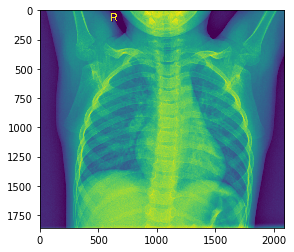

In [37]:
img = mpimg.imread(train_dir + 'NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

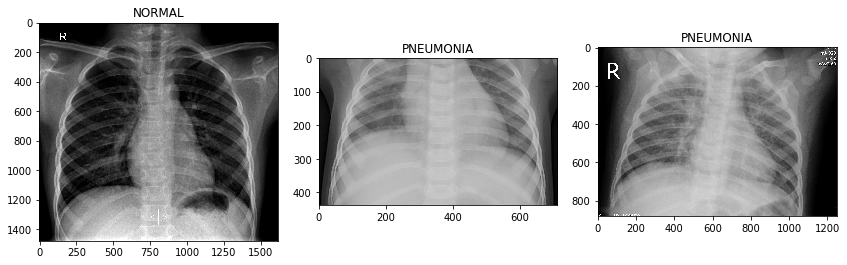

In [38]:
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0764-0001.jpeg')

img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person1_bacteria_1.jpeg')

img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person80_virus_150.jpeg')

# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [0]:
NUM_CLASSES = 2

def create_model(input_shape, num_classes):

  K.clear_session()
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)

  for layer in base_model.layers:
    layer.trainable = False
  predictions = Dense(num_classes, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3), NUM_CLASSES)

In [40]:
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)

test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
def dir_file_count(directory):
  return sum([len(files) for r, d, files in os.walk(directory)])

In [43]:
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5219 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.94159226 0.67341935]


In [45]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v1.hd5'
model.save(MODEL_FILE)

Epoch 1/10
11/11 [==============================] - 101s 9s/step - loss: 0.6714 - acc: 0.6158 - val_loss: 1.1100 - val_acc: 0.5000
Epoch 2/10
11/11 [==============================] - 71s 6s/step - loss: 0.5976 - acc: 0.7383 - val_loss: 1.1992 - val_acc: 0.5000
Epoch 3/10
11/11 [==============================] - 86s 8s/step - loss: 0.5634 - acc: 0.7427 - val_loss: 0.9062 - val_acc: 0.5000
Epoch 4/10
11/11 [==============================] - 86s 8s/step - loss: 0.5092 - acc: 0.7480 - val_loss: 0.7935 - val_acc: 0.5000
Epoch 5/10
11/11 [==============================] - 86s 8s/step - loss: 0.4625 - acc: 0.7639 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 6/10
11/11 [==============================] - 84s 8s/step - loss: 0.4008 - acc: 0.8162 - val_loss: 0.6545 - val_acc: 0.6250
Epoch 7/10
11/11 [==============================] - 86s 8s/step - loss: 0.3500 - acc: 0.8525 - val_loss: 0.8911 - val_acc: 0.5625
Epoch 8/10
11/11 [==============================] - 86s 8s/step - loss: 0.3058 - acc: 0.8

In [0]:
!mv {MODEL_FILE} '/content/drive/My Drive/Siraj/Week04-Healthcare'

In [0]:
MODEL_FILE = f'/content/drive/My Drive/Siraj/Week04-Healthcare/pneumonia_v1.hd5'
model = tf.keras.models.load_model(MODEL_FILE)

In [48]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 11s 11s/step - loss: 1.1759 - acc: 0.6458
Loss     : 1.18  
Accuracy : 64.58%


In [49]:
num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 64.58%
-----------------------------------
